In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


In [2]:
# The following classes can be heavily parallelized. Currently samples are collected over loops.

In [3]:
# Define the mixture model

class Mixture:
    # takes in an np array of parameters
    def __init__(self, fns, stds, weights):
        assert(np.sum(weights)==1.)
        self.num_components = len(fns)
        self.stds = stds 
        self.weights = weights
        self.fns = fns
    
    def sample(self, X, n):        
        y = []
        
        mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
        for i in range(n):
            mixture_id = mixture_idx[i]
            means = self.fns[mixture_id](X)
            std = self.stds[mixture_id]
            y_ = [ss.norm.rvs(m, std) for m in means]
            y.append(y_)
        return np.array(y).transpose()
    
    def prod(self, X, Y):
        # This is the pdf of each of the components on their own
        all_pdfs = []
        
        for x, y in zip(X, Y):
            p = []
            means = [f(x) for f in self.fns]
            
            for m, s, w in zip(means, self.stds, self.weights):
                p.append(ss.norm.pdf(y, loc=m, scale=s))
                
            all_pdfs.append(p)
        all_pdfs = np.array(all_pdfs)
        
        prod = np.prod(all_pdfs, axis=0)*self.weights
        
        return prod
        
        
    def pdf(self, X, Y):
        return np.sum(self.prod(X, Y))
    
    def condition(self, X, Y):

        pdf = self.pdf(X, Y)
        prod = self.prod(X, Y)
        self.weights = prod/pdf


In [4]:
# Define the moment matched prediction map for a mixture model

class MomentPredictionMap:
    # takes in an np array of parameters
    def __init__(self, mixture):
        self.mixture = mixture
        self.mean = self.get_mean(mixture)
        self.std = self.get_std(mixture)
        
    @staticmethod
    def get_mean(mixture):
        def mean(x):
            m = 0.
            for w, f in zip(mixture.weights, mixture.fns):
                m += w*f(x)
            return m
        return mean
    
    @staticmethod
    def get_std(mixture):
        def std(x):
            weighted_var = 0.
            weighted_mean = 0.
            weighted_mean_sqr = 0.
            for w, std, f in zip(mixture.weights, mixture.stds, mixture.fns):
                weighted_var += w * std**2
                weighted_mean += w * f(x)
                weighted_mean_sqr += w * f(x)**2
            return np.sqrt(weighted_var + weighted_mean_sqr - weighted_mean**2)
        return std
    

    def pdf(self, X, Y):
        p = []
        
        for x, y in zip(X, Y):    
            p.append(ss.norm.pdf(y, loc=self.mean(x), scale=self.std(x)))
                
        p = np.squeeze(np.array(p))        
        prod = np.prod(p, axis=0)
        
        return prod
    
    def sample(self, X, n):
        y = []
        for i in range(n):
            y_ = [ss.norm.rvs(self.mean(x), self.std(x)) for x in X]
            y.append(y_)
        return np.array(y).transpose()
        

In [5]:
# defining the parameters for and initializing a mixture model

def f1(x):
    return x**2 + 1. 
def f2(x):
    return x
def f3(x):
    return -x

fns = [f1, f2, f3]
stds = np.array([1., 0.5, 1.])
weights = np.array([0.25, 0.5, 0.25])


m = Mixture(fns, stds, weights)

In [6]:
# Computing the density of the mixture model at a collection of points

X = np.array([1., 2.]) 
Y = np.array([0.1, 0.3])

m.pdf(X,Y)

0.001737448997364714

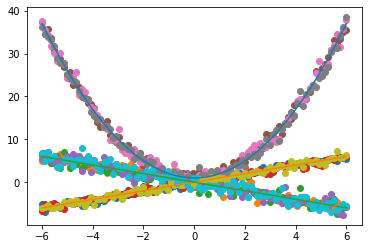

In [7]:
# Sampling from the mixture model

n_samples = 10
X = np.linspace(-6,6,100)
Y = np.array(m.sample(X, n_samples)) 

plt.plot(X, f1(X))
plt.plot(X, f2(X))
plt.plot(X, f3(X))

for i in range(n_samples):
    plt.scatter(X, Y[:, i])

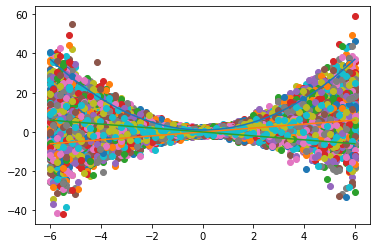

In [8]:
# Let's sample from the moment matched prediction map for this mixture model

mom_pred = MomentPredictionMap(m)

n_samples = 100
Y_ = mom_pred.sample(X, n_samples)
plt.plot(X, f1(X))
plt.plot(X, f2(X))
plt.plot(X, f3(X))

for i in range(n_samples):
    plt.scatter(X, Y_[:, i])

In [9]:
x_pred = np.array([1., 2., 4., 6])


In [10]:
m = Mixture(fns, stds, weights)
mom_pred = MomentPredictionMap(m)

n_samples = 20000
Y_mm_samples = []

#Sampling from the moment matched prediction map

for x in x_pred:
    Y_ = np.array(mom_pred.sample([x], n_samples)) 
    Y_mm_samples.append(Y_)
Y_mm_samples = np.squeeze(np.array(Y_mm_samples))


# plt.plot(X, f1(X))
# plt.plot(X, f2(X))
# plt.plot(X, f3(X))

# for i in range(n_samples):
#     plt.scatter(x_pred, Y_samples[:, i])

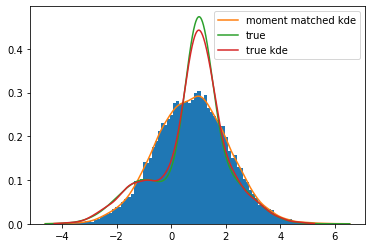

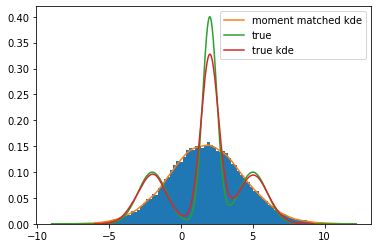

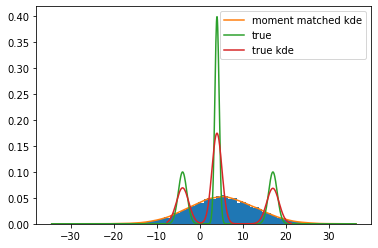

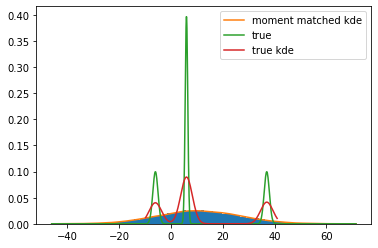

In [27]:
x_pred = np.array([1., 2., 4., 6])
m = Mixture(fns, stds, weights)
mm_kde_list = []
true_kde_list = []
for i in range(x_pred.shape[0]):
    plt.figure()    
    plt.hist(Y_mm_samples[i, :], bins=100, density=True)
    mm_kde = ss.gaussian_kde(Y_mm_samples[i, :])
    mm_kde_list.append(mm_kde)
    xx = np.linspace(np.min(Y_mm_samples[i, :]), np.max(Y_mm_samples[i, :]), 1000)

    plt.plot(xx, mm_kde(xx), label='moment matched kde')
    
    true_density = [m.pdf(np.array([x_pred[i]]), np.array([x_])) for x_ in xx]
    plt.plot(xx, true_density, label='true')
    
    true_samples = m.sample(np.array([x_pred[i]]), 20000)
    true_kde = ss.gaussian_kde(true_samples)
    true_xx = np.linspace(np.min(true_samples), np.max(true_samples), 1000)
    plt.plot(true_xx, true_kde(true_xx), label='true kde')
    true_kde_list.append(true_kde)
    plt.legend()


In [12]:
#objects generated 
true_kde_list
mm_kde_list

[[...], [...], [...], [...]]

In [13]:
n_samples = 20000

Y_samples = []

#Sampling from the moment matched prediction map
errors = 0
for i in range(n_samples):
    m = Mixture(fns, stds, weights)
    mom_pred = MomentPredictionMap(m)
    Y_ = []
    try:
        for i, x in enumerate(x_pred):
            y = np.array(mom_pred.sample(np.array([x]), 1))[0, :]
            
            Y_.append(y)
            m.condition(np.array([x]), y)
            mom_pred = MomentPredictionMap(m)
        Y_samples.append(Y_)
    except:
        print(Y_)
        errors +=1
        
        
Y_samples = np.transpose(np.squeeze(np.array(Y_samples)))

In [14]:
# plt.plot(X, f1(X))
# plt.plot(X, f2(X))
# plt.plot(X, f3(X))

# for i in range(Y_samples.shape[1]):
#     plt.scatter(x_pred, Y_samples[:, i])

In [15]:
errors

0

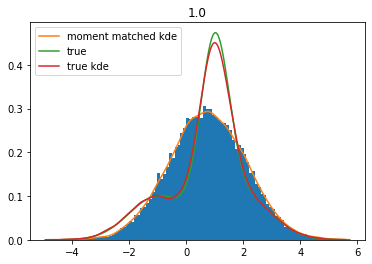

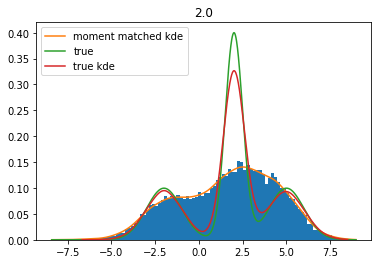

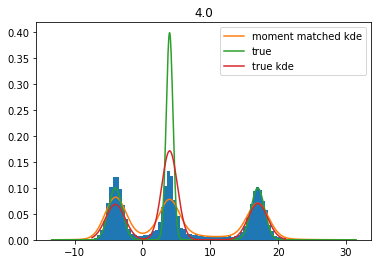

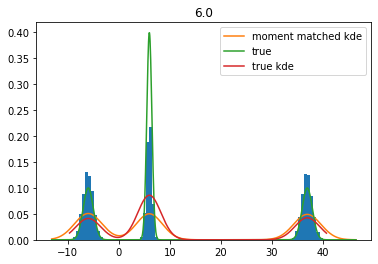

In [16]:
m = Mixture(fns, stds, weights)
ar_kde_list = []
for i in range(x_pred.shape[0]):
    plt.figure()    
    plt.hist(Y_samples[i, :], bins=100, density=True)
    plt.title(str(x_pred[i]))
    kde = ss.gaussian_kde(Y_samples[i, :])
    ar_kde_list.append(kde)
    xx = np.linspace(np.min(Y_samples[i, :]), np.max(Y_samples[i, :]), 1000)
    plt.plot(xx, kde(xx), label='moment matched kde')
    
    true_density = [m.pdf(np.array([x_pred[i]]), np.array([x_])) for x_ in xx]
    plt.plot(xx, true_density, label='true')
    
    true_samples = m.sample(np.array([x_pred[i]]), 20000)
    true_kde = ss.gaussian_kde(true_samples)
    true_xx = np.linspace(np.min(true_samples), np.max(true_samples), 1000)
    plt.plot(true_xx, true_kde(true_xx), label='true kde')
    
    plt.legend()


In [17]:
x_pred = np.array([6., 4., 2., 1.])
n_samples = 20000

Y_samples = []

#Sampling from the moment matched prediction map
errors = 0
for i in range(n_samples):
    m = Mixture(fns, stds, weights)
    mom_pred = MomentPredictionMap(m)
    Y_ = []
    try:
        for i, x in enumerate(x_pred):
            y = np.array(mom_pred.sample(np.array([x]), 1))[0, :]
            
            Y_.append(y)
            m.condition(np.array([x]), y)
            mom_pred = MomentPredictionMap(m)
        Y_samples.append(Y_)
    except:
        print(Y_)
        errors +=1
        
        
Y_samples = np.transpose(np.squeeze(np.array(Y_samples)))

/tmp/ipykernel_9075/1940466312.py:50: RuntimeWarning: invalid value encountered in true_divide
  self.weights = prod/pdf


[array([-46.80690097])]
[array([-46.06997145])]
[array([-46.46172036])]
[array([-46.16693303])]
[array([-47.90794166])]
[array([-48.88417117])]
[array([-48.05745305])]


In [18]:
# plt.plot(X, f1(X))
# plt.plot(X, f2(X))
# plt.plot(X, f3(X))

# for i in range(Y_samples.shape[1]):
#     plt.scatter(x_pred, Y_samples[:, i])

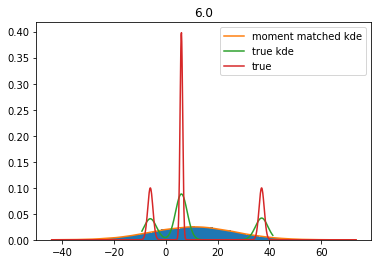

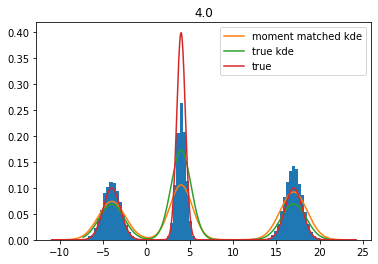

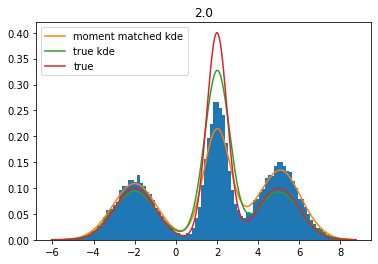

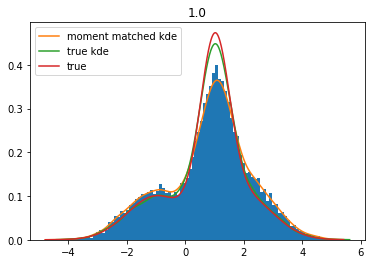

In [20]:
m = Mixture(fns, stds, weights)
rev_ar_kde_list = []
for i in range(x_pred.shape[0]):
    plt.figure()    
    plt.hist(Y_samples[i, :], bins=100, density=True)
    plt.title(str(x_pred[i]))
    kde = ss.gaussian_kde(Y_samples[i, :])
    rev_ar_kde_list.append(kde)
    xx = np.linspace(np.min(Y_samples[i, :]), np.max(Y_samples[i, :]), 1000)
    plt.plot(xx, kde(xx), label='moment matched kde')

    
    true_samples = m.sample(np.array([x_pred[i]]), 20000)
    true_kde = ss.gaussian_kde(true_samples)
    true_xx = np.linspace(np.min(true_samples), np.max(true_samples), 1000)
    plt.plot(true_xx, true_kde(true_xx), label='true kde')
    
    true_density = [m.pdf(np.array([x_pred[i]]), np.array([x_])) for x_ in xx]
    plt.plot(xx, true_density, label='true')
    plt.legend()
    

In [21]:
# gibbs sampling below

In [22]:
# x_pred = np.array(4*[1., 2., 4., 6., 4., 2.] + [1.])
# n_samples = 20000

# Y_samples = []

# #Sampling from the moment matched prediction map
# errors = 0
# for i in range(n_samples):
#     m = Mixture(fns, stds, weights)
#     mom_pred = MomentPredictionMap(m)
#     Y_ = []
#     try:
#         for i, x in enumerate(x_pred):
#             y = np.array(mom_pred.sample(np.array([x]), 1))[0, :]
            
#             Y_.append(y)
#             m.condition(np.array([x]), y)
#             mom_pred = MomentPredictionMap(m)
#         Y_samples.append(Y_)
#     except:
#         print(Y_)
#         errors +=1
        
        
# Y_samples = np.transpose(np.squeeze(np.array(Y_samples)))

In [23]:
# m = Mixture(fns, stds, weights)

# for i in range(x_pred.shape[0]):
#     plt.figure()    
#     plt.hist(Y_samples[i, :], bins=100, density=True)
#     plt.title(str(x_pred[i]))
#     kde = ss.gaussian_kde(Y_samples[i, :])
#     xx = np.linspace(np.min(Y_samples[i, :]), np.max(Y_samples[i, :]), 1000)
# #     plt.plot(xx, kde(xx), label='prediction')
    
#     true_density = [m.pdf(np.array([x_pred[i]]), np.array([x_])) for x_ in xx]
#     plt.plot(xx, true_density, label='true')
#     plt.legend()    
    
#     true_samples = m.sample(np.array([x_pred[i]]), 20000)
#     true_kde = ss.gaussian_kde(true_samples)
#     true_xx = np.linspace(np.min(true_samples), np.max(true_samples), 1000)
#     plt.plot(true_xx, true_kde(true_xx), label='true kde')
    
#     plt.legend()    


In [64]:
def make_gridplot(axes_off=False, figsize=(10, 10)):
    
    fig = plt.figure(constrained_layout=True, figsize=figsize)

    gs = GridSpec(10, 4, figure=fig)
    ax0 = fig.add_subplot(gs[:3, :])
    ax1 = fig.add_subplot(gs[3:, 0])
    ax2 = fig.add_subplot(gs[3:, 1])
    ax3 = fig.add_subplot(gs[3:, 2])
    ax4 = fig.add_subplot(gs[3:, 3])

    axs = [ax1, ax2, ax3, ax4]

#     ax0.set_xlim([0., 7.])
#     ax0.set_ylim([-0.5, 1.5])
#     ax0.set_xticks(np.linspace(-3., 3., 6), []*7)
#     ax0.set_yticks(np.linspace(-0.5, 1.5, 4), []*6)
#     ax0.grid(zorder=1)

    ax0.set_xlim([-0, 7])
#     ax0.set_ylim([-0.5, 1.5])
#     ax0.set_xticks(np.linspace(-3., 3., 6), []*6)
#     ax0.set_yticks(np.linspace(-0.5, 1.5, 4), []*4)
#     ax0.tick_params(left=False, bottom=False)
    ax0.set_xticks([])
    ax0.set_yticks([])
        
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        
        if axes_off:
            ax.axis("off")
    
    return fig, ax0, axs


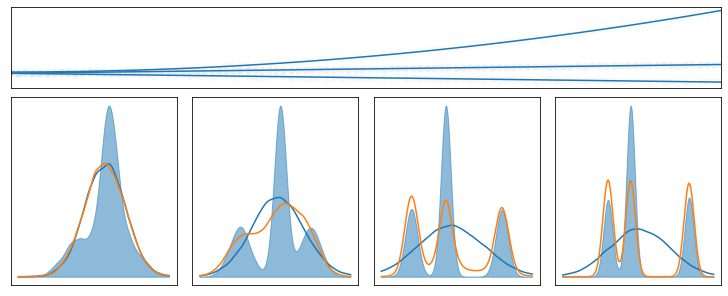

In [69]:
# xidx = (np.array([91, 133]) / 150 * 500).astype(np.int32)
# smin = x_samples.min()
# smax = x_samples.max()
# yplot = np.linspace(smin, smax, 200)
# samples = noisy_samples.elements[0][:, 0, 0, :]
xs = [np.linspace(-5, 5, 1000),
     np.linspace(-6, 9, 1000),
     np.linspace(-11, 24, 1000),
     np.linspace(-30, 50, 1000)
]

fig, ax0, axs = make_gridplot(figsize=(10, 4))


n_samples = 10
X = np.linspace(-0,7,100)
Y = np.array(m.sample(X, n_samples)) 

ax0.plot(X, f1(X), color='tab:blue')
# ax0.fill_between(X, f1(X)-1, f1(X) + 1)
ax0.plot(X, f2(X), color='tab:blue')
ax0.plot(X, f3(X), color='tab:blue')

for i in range(n_samples):
    ax0.scatter(X, Y[:, i], color='tab:blue', alpha=0.01)


for i, (ax) in enumerate(axs):
    rev_ar_kde = rev_ar_kde_list[3-i]
    ar_kde = ar_kde_list[i]
    mm_kde = mm_kde_list[i]
    true_kde = true_kde_list[i]
    x = xs[i]

    ax.fill_between(x, 0, true_kde(x), label='True', color='tab:blue', alpha=0.5)
    ax.plot(x, mm_kde(x), label='MM')
#     ax.plot(x, rev_ar_kde(x), label='Rev. AR')
    ax.plot(x, ar_kde(x), label='AR')

